In [37]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import spacy
import re

### Preprocessing the UK-Student Essay Data
I've got all of the student data I could ever need, with thousands of student submitted essays to choose from. I should be able to clean them all at once. I will also make sure that this step is done in a pipeline sort of way in case I need to scrape more data. This first spider crawls a list of subjects, and each subject contains a list of links to student submissions. The student submission pages contained the entire essay. So, my student crawler went 3 pages deep for each essay. It is also important to note here that the student crawler only selected three categories: Nursing, Law, and Business. This is because the number of professional samples (samples written by the site's paid authors) was limited to just these three subjects. Fortunately, these are the three most popular subjects and there are thousands of student submissions to choose from for each essay. After each scraper was run, I pulled its json output into a dataframe and used pickle to save it. This allows me to run the scraper and my analysis separately.

In [10]:
df_student = pickle.load(open('../uk_students.pkl', 'rb'))

# We can use this column to look at some summary statistics
df_student['joined'] = ([' '.join(each) for each in df_student.loc[:, 'text']])

# percent_remove = 0.2
# n_remove = int(len(df_student) * percent_remove)
# drop_indices = np.random.choice(df_student.index, n_remove, replace=False)
# df_student.drop(drop_indices, inplace=True)
df_student.reset_index(inplace=True, drop=True)

print('Number of student essays:', len(df_student))
df_student.head()

Number of student essays: 734


,subject,text,title,student,joined
0,Nursing,"[\n, \n, \n, \n, \n, Total Word Count: , This ...",Inquiry into Patient Death,1,\n \n \n \n \n Total Word Count: This report ...
1,Nursing,"[\n, \n, \n, \n, \n, Leadership has been descr...",Motivation Skills Development Plan for Nursing,1,\n \n \n \n \n Leadership has been described a...
2,Nursing,"[\n, \n, \n, \n, \n, Depression among pregnant...",Depression among Pregnant Adolescents: Literat...,1,\n \n \n \n \n Depression among pregnant adole...
3,Nursing,"[\n, \n, \n, \n, \n, Davidson, E., Daly, J., B...",Family Support Programme for ICU Patient Relat...,1,"\n \n \n \n \n Davidson, E., Daly, J., Brady, ..."
4,Nursing,"[\n, \n, \n, \n, \n, Idiopathic pulmonary fibr...",Idiopathic Pulmonary Fibrosis: An Overview,1,\n \n \n \n \n Idiopathic pulmonary fibrosis (...


In [11]:
lengths = pd.Series([len(each) for each in df_student.joined])
df_student['lengths'] = lengths
lengths.describe()

count      734.000000
mean     12997.242507
std       9506.293305
min         87.000000
25%       7777.750000
50%      12173.000000
75%      17417.750000
max      61642.000000
dtype: float64

Looks like we have some small essays

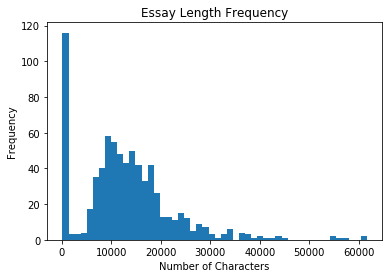

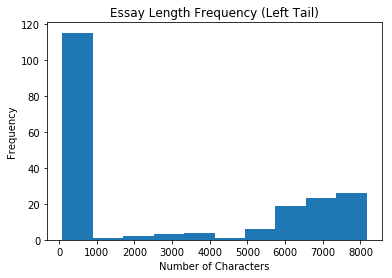

In [12]:
# I'm using a lot of bins because it is easier to see that there are a lot of very tiny essays
plt.hist(df_student.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Let's look a little closer at the left side
plt.hist(sorted(lengths)[:200], bins=10)
plt.title('Essay Length Frequency (Left Tail)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
# plt.xlim([0, 1000])
plt.show()

Let's go ahead and throw those small essays out

In [13]:
df_student = df_student[df_student['lengths'] > 1000]
df_student.reset_index(drop=True, inplace=True)

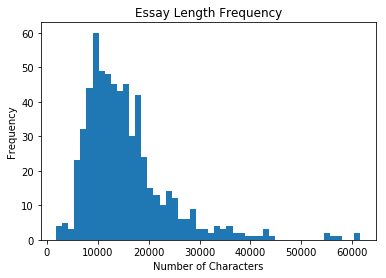

In [14]:
# I'm using a lot of bins because it is easier to see that there are a lot of very tiny essays
plt.hist(df_student.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [15]:
df_student.joined[0][:1000]

'\n \n \n \n \n Total Word Count:  This report has been prepared for the Bunbury Regional Hospital’s quality and safety committee, following the death of Josephine Wilma Troy on 14 February 2006. Mrs. Troy was a 63 year old lady who had been diagnosed with leukemia in 2004 and was treated with chemotherapy initially. The diagnosis was later refined to prolymphocytic leukemia, a rare chronic leukemia, as Mrs. Troy’s leukemia persisted in her bone marrow after an initial course of chemotherapy. Disease together with chemotherapy compromised her blood production capacity. She had low white blood count, low platelet count and low hemoglobin and was susceptible to infection and febrile neutropenia. Mrs. Troy had been issued with febrile neutropenia card to warn health care workers regarding her susceptibility to febrile neutropenia. On 12/02/2006, Mrs. Troy had a temperature of 38°C and attended Bunbury Regional Hospital with her card. She was started on antibiotic and a full blood screen w

The paragraphs are already separated for us, there are always 5 newlines at the beginning (you'll have to take my word for it), and the last two paragraphs are always a couple random characters and a statement about exporting the document. This will be really easy to clean up.

In [16]:
for i, text in enumerate(df_student.loc[:, 'text']):
    df_student.at[i, 'text'] = text[5:-2]
df_student.head()

,subject,text,title,student,joined,lengths
0,Nursing,"[Total Word Count: , This report has been prep...",Inquiry into Patient Death,1,\n \n \n \n \n Total Word Count: This report ...,8974
1,Nursing,"[Leadership has been described as ""a relationa...",Motivation Skills Development Plan for Nursing,1,\n \n \n \n \n Leadership has been described a...,18285
2,Nursing,[Depression among pregnant adolescents as well...,Depression among Pregnant Adolescents: Literat...,1,\n \n \n \n \n Depression among pregnant adole...,15238
3,Nursing,"[Davidson, E., Daly, J., Brady, R. & Higgins, ...",Family Support Programme for ICU Patient Relat...,1,"\n \n \n \n \n Davidson, E., Daly, J., Brady, ...",10071
4,Nursing,[Idiopathic pulmonary fibrosis (IPF) is a deva...,Idiopathic Pulmonary Fibrosis: An Overview,1,\n \n \n \n \n Idiopathic pulmonary fibrosis (...,16981


### Preprocessing the UK-Professional Essay Samples
As mentioned before, there are only about 30 samples posted on their website in their three most popular categories. We will be dealing with an imbalanced dataset, but we can deal with that when it comes time to model. Let's clean up the data and get some algorithms running.

In [17]:
# Pull in the dataframe produced by our UK_pro_scraper notebook
df_pro = pickle.load(open('../uk_pro.pkl', 'rb'))
print(df_pro.shape)
df_pro.head()

(33, 4)


,subject,text,title,student
0,nursing,"[\n, Discuss the impact of living with a long ...",Discuss the impact of living with a long term ...,0
1,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0
2,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0
3,nursing,"[\n, Discuss what effective leadership is and ...",Discuss what effective leadership is and argue...,0
4,law,"[\n, Case: Re: A (Children) (Conjoined Twins: ...",Case: Re: A (Children) (Conjoined Twins: Medic...,0


In [18]:
# Like before, let's see if any of these are too small
df_pro['joined'] = df_pro.text.map(' '.join) # I just (re)learned map. Map and I are going to be friends.
df_pro['lengths'] = df_pro.joined.map(len)
df_pro.head()

,subject,text,title,student,joined,lengths
0,nursing,"[\n, Discuss the impact of living with a long ...",Discuss the impact of living with a long term ...,0,\n Discuss the impact of living with a long te...,17674
1,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0,\n What is the Impact of Cutting down Nursing ...,18948
2,nursing,"[\n, What is the Impact of Cutting down Nursin...",What is the Impact of Cutting down Nursing Stu...,0,\n What is the Impact of Cutting down Nursing ...,15455
3,nursing,"[\n, Discuss what effective leadership is and ...",Discuss what effective leadership is and argue...,0,\n Discuss what effective leadership is and ar...,16561
4,law,"[\n, Case: Re: A (Children) (Conjoined Twins: ...",Case: Re: A (Children) (Conjoined Twins: Medic...,0,\n Case: Re: A (Children) (Conjoined Twins: Me...,11072


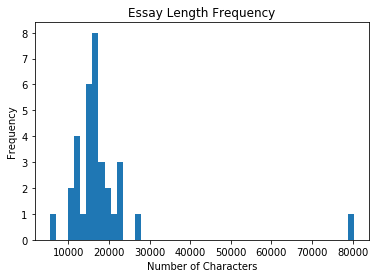

In [19]:
plt.hist(df_pro.lengths, bins=50)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

I think that everything in this dataset is worth keeping, especially because it is so small.

In [20]:
# The beginning of each example has: newline, title, newline
# We can get rid of this
[each[:3] for each in df_pro.text[:]][:5]

[['\n', 'Discuss the impact of living with a long term condition', '\n'],
 ['\n',
  'What is the Impact of Cutting down Nursing Student Bursary in the Future of Nursing Practice in the UK?',
  '\n'],
 ['\n',
  'What is the Impact of Cutting down Nursing Student Bursary in the Future of Nursing Practice in the UK?',
  '\n'],
 ['\n',
  'Discuss what effective leadership is and argue why it is deemed necessary in nursing practice',
  '\n'],
 ['\n',
  'Case: Re: A (Children) (Conjoined Twins: Medical Treatment) (No.1) [2000] 4 All ER 961.',
  '\n']]

In [21]:
# Each essay also cites sources at the end. We can get rid of those.
def find_ref_position(text):
    for i, piece in enumerate(text):
        if (piece.lower() == 'references') or (piece.lower() == 'reference'):
            return i

# Use my new friend 'map' to index where the references start
df_pro['ref_idx'] = df_pro.text.map(find_ref_position)

# Map might be good for this loop too. Looks prety skinny.
for i, text in enumerate(df_pro.text):
    try:
        # Delete everything after ref_idx
        df_pro.at[i, 'text'] = text[:int(df_pro.loc[i, 'ref_idx'])]
    except:
        pass

# Drop ref_idx. We don't need it anymore.
df_pro.drop(labels='ref_idx', axis=1, inplace=True)

# Get rid of titles, as noted before
df_pro['text'] = df_pro.text.map(lambda x: x[3:])
df_pro['joined'] = df_pro.text.map(' '.join)
df_pro.head()

,subject,text,title,student,joined,lengths
0,nursing,[There is increasing prevalence of people with...,Discuss the impact of living with a long term ...,0,There is increasing prevalence of people with ...,17674
1,nursing,"[In 2017, the government will end NHS bursarie...",What is the Impact of Cutting down Nursing Stu...,0,"In 2017, the government will end NHS bursaries...",18948
2,nursing,[This essay will critically explore the impact...,What is the Impact of Cutting down Nursing Stu...,0,This essay will critically explore the impact ...,15455
3,nursing,"[Introduction, \n, Leadership consists of vari...",Discuss what effective leadership is and argue...,0,Introduction \n Leadership consists of various...,16561
4,law,"[Notable Prior Precedents: , \n, Generally, un...",Case: Re: A (Children) (Conjoined Twins: Medic...,0,"Notable Prior Precedents: \n Generally, under...",11072


### Pulling Additional Pro Data
I tried to make the very small professional sample size work but unfortunately, it just wasn't cutting it. So, I got more data and I'm going to try and make it work this way.

In [22]:
# I ended up using an additional site for more professional samples
df_more_pro = pickle.load(open('../grademiner_pro.pkl', 'rb'))
print(df_more_pro.shape)
df_more_pro.head()

(59, 4)


,subject,text,title,student
0,Nursing,"[\n , Introduction, \r\...",Patient safety in the operating room,0
1,Nursing,"[\n , Statement of the ...",Pain Management and Alternative Therapies,0
2,Nursing,[\n The purpose of vent...,The purpose of ventilatory management,0
3,Business,[\n Family owned busine...,Family Business Succession,0
4,Business,"[\n , Business Case Ana...",Business case report essay,0


In [23]:
# Like before, let's see if any of these are too small
df_more_pro['joined'] = df_more_pro.text.map(' '.join) # I just (re)learned map. Map and I are going to be friends.
df_more_pro['lengths'] = df_more_pro.joined.map(len)
df_more_pro.head()

,subject,text,title,student,joined,lengths
0,Nursing,"[\n , Introduction, \r\...",Patient safety in the operating room,0,\n Introduction \r\nPa...,15255
1,Nursing,"[\n , Statement of the ...",Pain Management and Alternative Therapies,0,\n Statement of the Pr...,2233
2,Nursing,[\n The purpose of vent...,The purpose of ventilatory management,0,\n The purpose of venti...,6402
3,Business,[\n Family owned busine...,Family Business Succession,0,\n Family owned busines...,13416
4,Business,"[\n , Business Case Ana...",Business case report essay,0,\n Business Case Analy...,9714


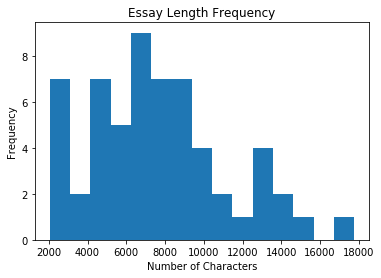

In [24]:
plt.hist(df_more_pro.lengths, bins=15)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [25]:
'''
The beginning of each example has different things to start. Sometimes it's
a title, sometimes it's just a newline. Let's cutoff every string that is
shorter than ... 80 characters? I got that number through trial and error
plus visual inspection.
'''

def cutoff_first_lines(text):
    cutoff_value = 80
    for i, string in enumerate(text):
        if len(string) > cutoff_value:
            return text[i:]

df_more_pro.text = df_more_pro.text.map(cutoff_first_lines)

In [26]:
# Each essay also cites sources at the end. We can get rid of those.
def find_ref_position(text):
    for i, piece in enumerate(text):
        if (piece.lower() == 'references') or (piece.lower() == 'reference') or (piece.lower() == 'references:'):
            return i

# Use my new friend 'map' to index where the references start
df_more_pro['ref_idx'] = df_more_pro.text.map(find_ref_position)

# Map might be good for this loop too. Looks prety skinny.
for i, text in enumerate(df_more_pro.text):
    try:
        # Delete everything after ref_idx
        df_more_pro.at[i, 'text'] = text[:int(df_more_pro.loc[i, 'ref_idx'])]
    except:
        pass
    
# Drop ref_idx. We don't need it anymore.
df_more_pro.drop(labels='ref_idx', axis=1, inplace=True)

# Get rid of titles, as noted before
df_more_pro['joined'] = df_more_pro.text.map(' '.join)
df_more_pro.head()

,subject,text,title,student,joined,lengths
0,Nursing,[\r\nPatient safety in the operating room is o...,Patient safety in the operating room,0,\r\nPatient safety in the operating room is on...,15255
1,Nursing,[\r\nPain management is a long-standing issue ...,Pain Management and Alternative Therapies,0,\r\nPain management is a long-standing issue i...,2233
2,Nursing,[\n The purpose of vent...,The purpose of ventilatory management,0,\n The purpose of venti...,6402
3,Business,[\n Family owned busine...,Family Business Succession,0,\n Family owned busines...,13416
4,Business,"[Siam Canadian Co., Ltd. was founded in 1987 b...",Business case report essay,0,"Siam Canadian Co., Ltd. was founded in 1987 by...",9714


In [27]:
# Now we will combine the old pros with the new using the .append() method
df_pro = df_pro.append(df_more_pro, ignore_index=True)
print(df_pro.shape)
df_pro.head()

(92, 6)


,subject,text,title,student,joined,lengths
0,nursing,[There is increasing prevalence of people with...,Discuss the impact of living with a long term ...,0,There is increasing prevalence of people with ...,17674
1,nursing,"[In 2017, the government will end NHS bursarie...",What is the Impact of Cutting down Nursing Stu...,0,"In 2017, the government will end NHS bursaries...",18948
2,nursing,[This essay will critically explore the impact...,What is the Impact of Cutting down Nursing Stu...,0,This essay will critically explore the impact ...,15455
3,nursing,"[Introduction, \n, Leadership consists of vari...",Discuss what effective leadership is and argue...,0,Introduction \n Leadership consists of various...,16561
4,law,"[Notable Prior Precedents: , \n, Generally, un...",Case: Re: A (Children) (Conjoined Twins: Medic...,0,"Notable Prior Precedents: \n Generally, under...",11072


# Additional Scraped Nursing Data
Again, I have found additional data to use, this time it is all about nursing.

In [28]:
df_nursing = pickle.load(open('../nursing_pro.pkl', 'rb'))
print(df_nursing.shape)
df_nursing.head()

(20, 4)


,subject,text,title,student
0,Nursing,[Treatment Alternatives and Stepwise Managemen...,\n\t\t\tASTHMA AND STEPWISE MANAGEMENT,0
1,Nursing,[The basic theoretical assertions or propositi...,\n\t\t\tNursing Theories,0
2,Nursing,[Discuss why a nursing center should be starte...,\n\t\t\tThe Nursing Center and Nurse Practitio...,0
3,Nursing,"[For a majority of women, missing a menstrual ...",\n\t\t\tNursing Care of the Family During Preg...,0
4,Nursing,[The Health Belief Model is the most used theo...,\n\t\t\tThe Health Belief Model,0


In [29]:
# Like before, let's see if any of these are too small
df_nursing['joined'] = df_nursing.text.map(' '.join) 
df_nursing['lengths'] = df_nursing.joined.map(len)
df_nursing.head()

,subject,text,title,student,joined,lengths
0,Nursing,[Treatment Alternatives and Stepwise Managemen...,\n\t\t\tASTHMA AND STEPWISE MANAGEMENT,0,Treatment Alternatives and Stepwise Management...,4329
1,Nursing,[The basic theoretical assertions or propositi...,\n\t\t\tNursing Theories,0,The basic theoretical assertions or propositio...,3885
2,Nursing,[Discuss why a nursing center should be starte...,\n\t\t\tThe Nursing Center and Nurse Practitio...,0,Discuss why a nursing center should be started...,2406
3,Nursing,"[For a majority of women, missing a menstrual ...",\n\t\t\tNursing Care of the Family During Preg...,0,"For a majority of women, missing a menstrual p...",1843
4,Nursing,[The Health Belief Model is the most used theo...,\n\t\t\tThe Health Belief Model,0,The Health Belief Model is the most used theor...,2352


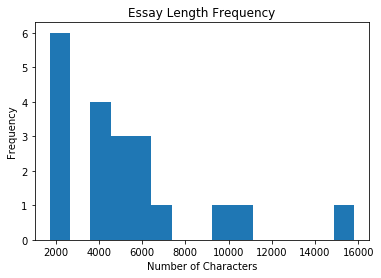

In [30]:
plt.hist(df_nursing.lengths, bins=15)
plt.title('Essay Length Frequency')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

In [31]:
df_nursing.text[5]

['With the advancement of technology, Healthcare institutions are slowly adopting use of technology in offering their services. Some of these technologies are so complex and may require step by step guidance in order to understand the whole process. This step by step guidance is usually referred to as tutorial. A number of tutorials are available for different actions. 3M coding is a health care data base for storing patient information. In order to understand on the use as well as each feature of 3M CRS training is provided. This training is an on demand training aimed at showing how the 3M coding product features. ',
 'There are a number of tutorials which are used in providing training. Some of the tutorials which can be used in providing training are; “Tutorial on entering of the patient’s information; starting a guided coding session; completing a guided coding session; Coding complex diagnoses and procedures; changing your coding selections and entering codes by code number.”',
 

In [32]:
# Each essay also cites sources at the end. We can get rid of those.
def find_ref_position(text):
    for i, piece in enumerate(text):
        if (piece.lower() == 'references') or (piece.lower() == 'reference') or (piece.lower() == 'references:'):
            return i

# Use my new friend 'map' to index where the references start
df_nursing['ref_idx'] = df_nursing.text.map(find_ref_position)

# Map might be good for this loop too. Looks prety skinny.
for i, text in enumerate(df_nursing.text):
    try:
        # Delete everything after ref_idx
        df_nursing.at[i, 'text'] = text[:int(df_nursing.loc[i, 'ref_idx'])]
    except:
        pass
    
# Drop ref_idx. We don't need it anymore.
df_nursing.drop(labels='ref_idx', axis=1, inplace=True)

# Get rid of titles, as noted before
df_nursing['joined'] = df_nursing.text.map(' '.join)
df_nursing.head()

,subject,text,title,student,joined,lengths
0,Nursing,[Treatment Alternatives and Stepwise Managemen...,\n\t\t\tASTHMA AND STEPWISE MANAGEMENT,0,Treatment Alternatives and Stepwise Management...,4329
1,Nursing,[The basic theoretical assertions or propositi...,\n\t\t\tNursing Theories,0,The basic theoretical assertions or propositio...,3885
2,Nursing,[Discuss why a nursing center should be starte...,\n\t\t\tThe Nursing Center and Nurse Practitio...,0,Discuss why a nursing center should be started...,2406
3,Nursing,"[For a majority of women, missing a menstrual ...",\n\t\t\tNursing Care of the Family During Preg...,0,"For a majority of women, missing a menstrual p...",1843
4,Nursing,[The Health Belief Model is the most used theo...,\n\t\t\tThe Health Belief Model,0,The Health Belief Model is the most used theor...,2352


In [33]:
# Now we will combine the old pros with the new using the .append() method
df_pro = df_pro.append(df_nursing, ignore_index=True)
print(df_pro.shape)
df_pro.head()

(112, 6)


,subject,text,title,student,joined,lengths
0,nursing,[There is increasing prevalence of people with...,Discuss the impact of living with a long term ...,0,There is increasing prevalence of people with ...,17674
1,nursing,"[In 2017, the government will end NHS bursarie...",What is the Impact of Cutting down Nursing Stu...,0,"In 2017, the government will end NHS bursaries...",18948
2,nursing,[This essay will critically explore the impact...,What is the Impact of Cutting down Nursing Stu...,0,This essay will critically explore the impact ...,15455
3,nursing,"[Introduction, \n, Leadership consists of vari...",Discuss what effective leadership is and argue...,0,Introduction \n Leadership consists of various...,16561
4,law,"[Notable Prior Precedents: , \n, Generally, un...",Case: Re: A (Children) (Conjoined Twins: Medic...,0,"Notable Prior Precedents: \n Generally, under...",11072


### Combining the datasets

In [34]:
df_features = df_student.loc[:, ['subject', 'joined', 'student']]
df_features = df_features.append(df_pro.loc[:, ['subject', 'joined', 'student']])

# Empty columns for processed text
df_features['tokens'] = None
df_features['lemmas'] = None
df_features.student = df_features.student.map(lambda x: 'student' if x == 1 else 'pro')
print(df_features.shape)
df_features.head()

(730, 5)


,subject,joined,student,tokens,lemmas
0,Nursing,\n \n \n \n \n Total Word Count: This report ...,student,None,None
1,Nursing,\n \n \n \n \n Leadership has been described a...,student,None,None
2,Nursing,\n \n \n \n \n Depression among pregnant adole...,student,None,None
3,Nursing,"\n \n \n \n \n Davidson, E., Daly, J., Brady, ...",student,None,None
4,Nursing,\n \n \n \n \n Idiopathic pulmonary fibrosis (...,student,None,None


# Text Cleaning and Tokenization
We've done it before but it is always necessary. We will be using the nlp text cleaner from spacy in order to utilize their lemmatizers. Also, feature engineering.

In [38]:
def text_cleaner(text):
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

nlp = spacy.load('en')

def my_lemmatizer(text):
    return ' '.join([token.lemma_ for token in text])

# I love map so much. This has changed my coding life!
df_features.joined = df_features.joined.map(text_cleaner)
df_features.tokens = df_features.joined.map(nlp)
df_features.lemmas = df_features.tokens.map(my_lemmatizer)
df_features.reset_index(drop=True, inplace=True)
df_features.head()

,subject,joined,student,tokens,lemmas
0,Nursing,Total Word Count: This report has been prepare...,student,"(Total, Word, Count, :, This, report, has, bee...",total word count : this report have be prepare...
1,Nursing,"Leadership has been described as ""a relational...",student,"(Leadership, has, been, described, as, "", a, r...","leadership have be describe as "" a relational ..."
2,Nursing,Depression among pregnant adolescents as well ...,student,"(Depression, among, pregnant, adolescents, as,...",depression among pregnant adolescent as well a...
3,Nursing,"Davidson, E., Daly, J., Brady, R. & Higgins, P...",student,"(Davidson, ,, E., ,, Daly, ,, J., ,, Brady, ,,...","davidson , e. , daly , j. , brady , r. & higgi..."
4,Nursing,Idiopathic pulmonary fibrosis (IPF) is a devas...,student,"(Idiopathic, pulmonary, fibrosis, (, IPF, ), i...",idiopathic pulmonary fibrosis ( ipf ) be a dev...


In [47]:
# One last thing, I need to change the subjects so that they are all exactly the same. This means
# getting rid of spaces and capitalization.
df_features.subject = df_features.subject.map(lambda x: x.lower().strip(' '))
df_features.subject.value_counts()

business    285
nursing     281
law         164
Name: subject, dtype: int64

In [48]:
# Most corpora are measured in total number of words, so I'm curious to see what we are working with here
total_corpus_length = df_features.tokens.map(lambda x: len([token for token in x if not token.is_punct]))
print('Total number of words in corpus: ', total_corpus_length.sum())

Total number of words in corpus:  1660345


In [49]:
pickle.dump(df_features, open('../df_features.pkl', 'wb'))